# Price Pridiction for Holiday Listings.csv
## One copy of the code for Non-holiday Listings.csv

In [244]:
# For Analysis
import numpy as np
import pandas as pd

# For Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# For Calculations
from math import floor

#For Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression , Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
import os
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from catboost import CatBoostRegressor
from sklearn import preprocessing

# For Validation
from sklearn.metrics import mean_squared_error, accuracy_score

# For Storing Models
import pickle
%matplotlib inline

# For Warnings
import warnings
warnings.filterwarnings("ignore")

In [245]:
holiday_listings = pd.read_csv("..\dataset_filter\listings_combine_season.csv")

In [246]:
# holiday_listings = pd.read_csv("..\dataset_filter\Tier_2.csv")

In [247]:
holiday_listings.columns

Index(['Rank', 'Name', 'Walk_Score', 'Transit_Score', 'Bike_Score',
       'Population', 'listing_id', 'listing_url', 'last_scraped', 'name',
       ...
       'Pet_Friendly', 'Pool', 'Safety_Features', 'Security_Features',
       'Smoking_Allowed', 'Suitable_for_Events', 'TV', 'Weather_Control',
       'price_holiday', 'price_nonholiday'],
      dtype='object', length=110)

## These columns should drop in data cleasing or somewhere else

In [248]:
holiday_listings.drop(columns=['Rank', 'Name', 'listing_id', 'Population', 'price'], inplace=True)

In [249]:
holiday_listings.head(n=2)

,Walk_Score,Transit_Score,Bike_Score,listing_url,last_scraped,name,summary,space,description,experiences_offered,...,Pet_Friendly,Pool,Safety_Features,Security_Features,Smoking_Allowed,Suitable_for_Events,TV,Weather_Control,price_holiday,price_nonholiday
0,98.0,100.0,80.0,https://www.airbnb.com/rooms/365550,4/1/2016,contemporary art loft downtown [17],** Please read our entire listing description ...,This is studio #17 - one of two private airbnb...,** Please read our entire listing description ...,none,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,114.000000,98.672340
1,98.0,100.0,80.0,https://www.airbnb.com/rooms/7777381,4/1/2016,Privacy & gorgeous panoramic views!,This beautiful apartment is all about location...,Your private oasis features stunning panoramic...,This beautiful apartment is all about location...,none,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,82.826087,82.745098


In [250]:
def preprocess(df):
    temp_df = df.copy()
    ## Recode property_type
    def recode_prop(value):
        if value not in ['House', 'Apartment','Condominium','Townhouse','Loft']:
            return 'other_prop_type'
        return value

    temp_df['property_type'] = temp_df['property_type'].apply(recode_prop)

    ## Recode bed_type
    def recode_bed(value):
        if value not in ['Real Bed']:
            return 'other_bed_type'
        return value

    temp_df['bed_type'] = temp_df['bed_type'].apply(recode_bed)
        
    #Calculate the bedroom and bathroom share per person. Higher the share, more the comfort.
    temp_df = temp_df.assign(
        bedroom_share = temp_df.bedrooms/temp_df.accommodates,
        bathroom_share = temp_df.bathrooms/temp_df.accommodates,
        
    )
    
    df=temp_df
    print("Pre-processing completed...")
    return df

In [251]:
#Preprocess the listings data
holiday_listings=preprocess(holiday_listings)

Pre-processing completed...


In [252]:
#Create dummy columns by one-hot encoding
def create_dummies(df, columns = ['room_type', 'property_type', 'bed_type', 'cancellation_policy']):
    for column in columns:
        dummies = pd.get_dummies(df[column], prefix = column)
        df = pd.concat([df,dummies], axis = 1)
    return df

In [253]:
# Create the required dummy columns
holiday_listings = create_dummies(holiday_listings)

# 1. Create Model Function: 
* train_set:test_set = 8:2
* Display R^2 and MSE for comparing different models

In [254]:
# Collect R^2 and RMSE for all models into a list
r_2_train_holiday = []
rmse_train_holiday = []
r_2_train_nonholiday = []
rmse_train_nonholiday = []

r_2_test_holiday = []
rmse_test_holiday = []
r_2_test_nonholiday = []
rmse_test_nonholiday = []

In [255]:
#Creating the train and test split
np.random.seed(2018)
train = np.random.choice([True, False], holiday_listings.shape[0], replace=True, p=[0.8, 0.2])
listings_train = holiday_listings.iloc[train,:]
listings_test = holiday_listings.iloc[~train,:]

In [256]:
# list(listings_train)

In [257]:
def model_listing(regr,train_cols,target_col):
    
    x_train = listings_train[train_cols].values
    x_test = listings_test[train_cols].values
    y_train = listings_train[target_col].values
    y_test = listings_test[target_col].values
    
    print("Shape of Train and Test data")
    print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
    print(" ------------------------------------------ ")
    
    #Min Max Scaling

    #scaler = MinMaxScaler()
    #x_train = scaler.fit_transform(x_train)
    #x_test = scaler.transform(x_test)
    
    # Declare an instance of the Linear Regression model.
    rg = regr()

    # Fit the model on to the training data( Train the model ).
    rg.fit(x_train, y_train)
    
    # Use the model to predict values
    y_pred = rg.predict(x_train)

    rmse_value_train = mean_squared_error(y_train,y_pred)**0.5

    # Calculate the Mean Squared Error using the mean_squared_error function.
    print("Training Data")
    print("R^2 value using score fn: %.3f" % rg.score(x_train,y_train))
    print("Root Mean Squared Error : %0.3f" % (rmse_value_train))
    print(" ------------------------------------------ ")
    # Use the model to predict values
    y_pred = rg.predict(x_test)

    rmse_value_test =  mean_squared_error(y_test,y_pred)**0.5
    # Calculate the Mean Squared Error using the mean_squared_error function.
    print("Test Data")
    print("R^2 value using score fn: %.3f" % rg.score(x_test,y_test))
    print("Root Mean Squared Error : %0.3f" % (rmse_value_test))
    print(" ------------------------------------------ ")

    
    lin_reg_coef = pd.DataFrame(list(zip(train_cols,(rg.coef_))),columns=['Feature','Coefficient'])
    print(lin_reg_coef.sort_values(by='Coefficient',ascending=False))
    print(" ------------------------------------------ ")
    
    # #Collect scores
    r_2_train_holiday.append(rg.score(x_train,y_train))
    r_2_test_holiday.append(rg.score(x_test,y_test))
    rmse_train_holiday.append(rmse_value_train)
    rmse_test_holiday.append(rmse_value_test)

    # Plot of model's residuals:
    fig = plt.figure(figsize=(10,3))

    sns.regplot(y_test,y_pred)
    plt.title("Residuals for the model")

# Model 1: Linear Regresson + Basic Features
## Basic Features are analyzed in the EDA, which have a high corelation with Price

In [258]:
# square_feet dropped in dropna > 30%
basic_features = ['accommodates','bathrooms','bedrooms','beds','guests_included']

basic_features2 = [ 
    'bed_type_Real Bed',
    'property_type_Condominium','property_type_Townhouse',
    'room_type_Entire home/apt', 'room_type_Private room',
    'property_type_Apartment','property_type_House', 
    'cancellation_policy_flexible', 'cancellation_policy_moderate','instant_bookable']
basic_features = basic_features + basic_features2

In [259]:
basic_features

['accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'guests_included',
 'bed_type_Real Bed',
 'property_type_Condominium',
 'property_type_Townhouse',
 'room_type_Entire home/apt',
 'room_type_Private room',
 'property_type_Apartment',
 'property_type_House',
 'cancellation_policy_flexible',
 'cancellation_policy_moderate',
 'instant_bookable']

Shape of Train and Test data
(3018, 15) (800, 15) (3018,) (800,)
 ------------------------------------------ 
Training Data
R^2 value using score fn: 0.567
Root Mean Squared Error : 70.908
 ------------------------------------------ 
Test Data
R^2 value using score fn: 0.560
Root Mean Squared Error : 69.269
 ------------------------------------------ 
                         Feature  Coefficient
8      room_type_Entire home/apt    68.735498
1                      bathrooms    45.546087
9         room_type_Private room    35.024563
2                       bedrooms    22.859983
0                   accommodates    14.385106
14              instant_bookable     8.384782
3                           beds     6.347636
6      property_type_Condominium     1.225131
4                guests_included    -1.277299
10       property_type_Apartment    -1.599777
5              bed_type_Real Bed    -2.738629
12  cancellation_policy_flexible   -20.126772
13  cancellation_policy_moderate   -24.383632
11

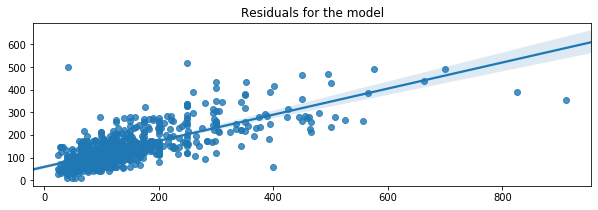

In [260]:
# EDA part
train_cols = basic_features

target_col = 'price_holiday'
model_listing(LinearRegression,train_cols,target_col)

# Model 2: Linear Regresson + Basic Features + Amenities Features
## Amenities are extracted by using One-Hot Encoding

In [261]:
ammenity_features = ['24-Hour_Check-in', 'Access_Friendly', 'Breakfast', 'Essentials',
       'Family/Kid_Friendly', 'Free_Parking_on_Premises', 'Gym', 'Hot_Tub',
       'Internet', 'Kitchen', 'Laundry_Facility', 'Pet_Friendly', 'Pool',
       'Safety_Features', 'Security_Features', 'Smoking_Allowed',
       'Suitable_for_Events', 'TV', 'Weather_Control']
train_cols = basic_features + ammenity_features

Shape of Train and Test data
(3018, 34) (800, 34) (3018,) (800,)
 ------------------------------------------ 
Training Data
R^2 value using score fn: 0.606
Root Mean Squared Error : 67.619
 ------------------------------------------ 
Test Data
R^2 value using score fn: 0.605
Root Mean Squared Error : 65.664
 ------------------------------------------ 
                         Feature  Coefficient
8      room_type_Entire home/apt    73.790028
1                      bathrooms    41.634270
9         room_type_Private room    38.290790
2                       bedrooms    26.914282
30               Smoking_Allowed    19.311287
0                   accommodates    12.152175
23                      Internet     9.050705
26                  Pet_Friendly     7.169113
14              instant_bookable     6.525209
3                           beds     6.313569
20      Free_Parking_on_Premises     4.756536
19           Family/Kid_Friendly     4.471960
24                       Kitchen     3.376612
25

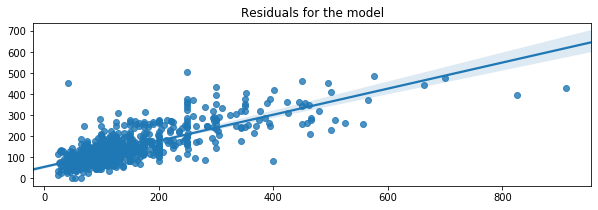

In [262]:
target_col = 'price_holiday'

model_listing(LinearRegression,train_cols,target_col)

# Model 3" Linear Regresson + Basic Features + Amenities Features + Seattle Score Features
## Seattle-Score Features are extracted from another Dataset,   .csv

Shape of Train and Test data
(3018, 37) (800, 37) (3018,) (800,)
 ------------------------------------------ 
Training Data
R^2 value using score fn: 0.613
Root Mean Squared Error : 67.040
 ------------------------------------------ 
Test Data
R^2 value using score fn: 0.610
Root Mean Squared Error : 65.210
 ------------------------------------------ 
                         Feature  Coefficient
8      room_type_Entire home/apt    76.110268
9         room_type_Private room    40.751592
1                      bathrooms    40.639774
2                       bedrooms    28.104523
30               Smoking_Allowed    19.023153
0                   accommodates    11.990402
23                      Internet    10.028900
14              instant_bookable     6.822201
26                  Pet_Friendly     6.450042
3                           beds     6.089109
19           Family/Kid_Friendly     4.152666
24                       Kitchen     3.784348
20      Free_Parking_on_Premises     2.744292
29

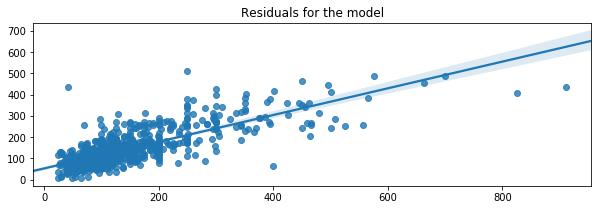

In [263]:
neiborhood_score = ['Walk_Score', 'Transit_Score', 'Bike_Score']
train_cols = basic_features + ammenity_features + neiborhood_score

target_col = 'price_holiday'

model_listing(LinearRegression,train_cols,target_col)

# To solve overfitting, Regularization is applied......

In [264]:
# Function to calculate regularized cost given alpha, mse and the model coefficients
def reg_cost(alpha, mse, coeffs, model = None):
    if model == "lasso":
        return mse + alpha * np.sum(np.abs(coeffs))
    elif model == "ridge":
        return mse + alpha * np.linalg.norm(coeffs)
    else:
        return mse

In [265]:
alpha_levels = [0, 0.1 , 0.5, 1, 10, 20, 30, 40, 50, 100]
r2_refine_test = []
rmse_refine_test = []
x_train = listings_train[train_cols].values
x_test = listings_test[train_cols].values
y_train = listings_train[target_col].values
y_test = listings_test[target_col].values

for alpha_level in alpha_levels:
    print("\n At alpha Level: %0.2f "% alpha_level)

    lasso_lm = Lasso(alpha= alpha_level)

    # Fit the model on to the training data( Train the model ).
    lasso_lm.fit(x_train, y_train)

    # Use the model to predict values
    #y_pred = np.expm1(lm.predict(x_test))
    y_pred = lasso_lm.predict(x_test)

    # Calculate the Mean Squared Error using the mean_squared_error function.
    rmse_fine = mean_squared_error(y_test,y_pred)**0.5
    print("Test Data")
    print("R^2 value using score fn: %.3f" % lasso_lm.score(x_test,y_test))
    print("Root Mean Squared Error : %0.3f" % (rmse_fine))
       
    # Get model complexity using the user defined fn
    print("Model Complexity: %0.3f" % reg_cost(mse = 0, alpha = 1, coeffs= lasso_lm.coef_, model= "lasso"))
    
    # Get Regularized Cost using the user defined fn
    print("Regularized Cost: %0.3f" % reg_cost(mse = mean_squared_error(y_test,y_pred), alpha = alpha_level, coeffs= lasso_lm.coef_, model= "lasso"))
    r2_refine_test.append(lasso_lm.score(x_test,y_test))
    rmse_refine_test.append(rmse_fine)


 At alpha Level: 0.00 
Test Data
R^2 value using score fn: 0.610
Root Mean Squared Error : 65.210
Model Complexity: 493.272
Regularized Cost: 4252.355

 At alpha Level: 0.10 
Test Data
R^2 value using score fn: 0.611
Root Mean Squared Error : 65.169
Model Complexity: 392.078
Regularized Cost: 4286.185

 At alpha Level: 0.50 
Test Data
R^2 value using score fn: 0.603
Root Mean Squared Error : 65.801
Model Complexity: 229.135
Regularized Cost: 4444.290

 At alpha Level: 1.00 
Test Data
R^2 value using score fn: 0.599
Root Mean Squared Error : 66.093
Model Complexity: 195.126
Regularized Cost: 4563.470

 At alpha Level: 10.00 
Test Data
R^2 value using score fn: 0.532
Root Mean Squared Error : 71.427
Model Complexity: 47.874
Regularized Cost: 5580.533

 At alpha Level: 20.00 
Test Data
R^2 value using score fn: 0.501
Root Mean Squared Error : 73.771
Model Complexity: 33.143
Regularized Cost: 6104.999

 At alpha Level: 30.00 
Test Data
R^2 value using score fn: 0.489
Root Mean Squared Err

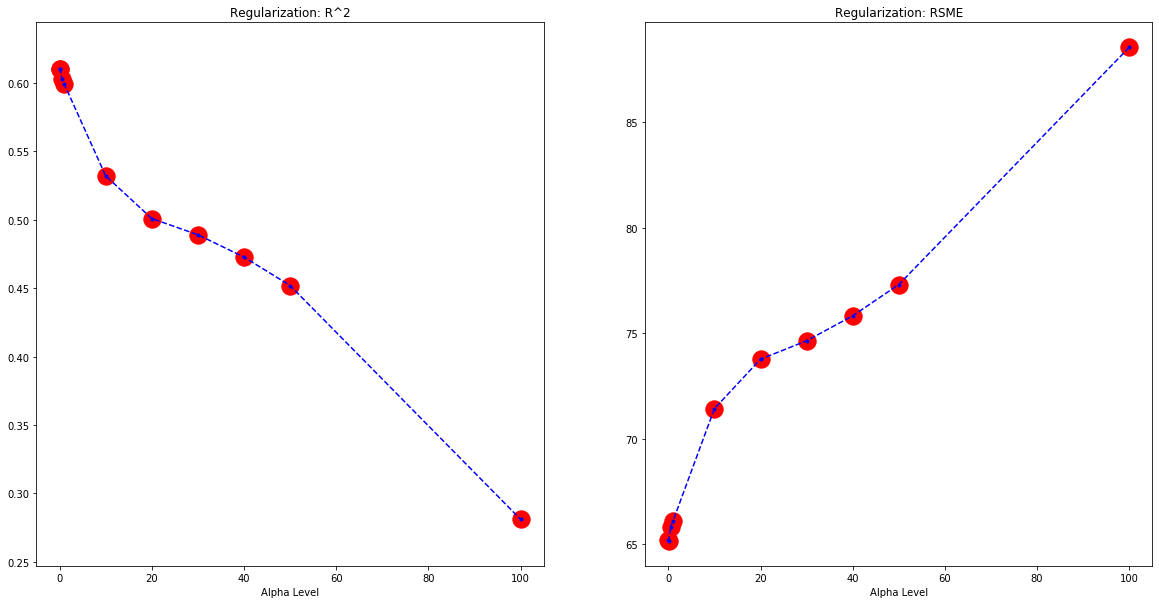

In [266]:
# f, axes = plt.subplots(1, 2, figsize=(18, 20))
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_xlabel('Alpha Level')# Draw the distributions of all variables
x_coordinates = [0, 0.1 , 0.5, 1, 10, 20, 30, 40, 50, 100]
y_coordinate_ = r2_refine_test
ax1.set_title("Regularization: R^2")
ax1.set_xlabel('Alpha Level')
ax1.scatter(x_coordinates, y_coordinate_, s = 300, c='red')
ax1.plot(x_coordinates, y_coordinate_, '.b--')
y_coordinate_ = rmse_refine_test
ax2.set_title("Regularization: RSME")
ax2.set_xlabel('Alpha Level')
ax2.scatter(x_coordinates, y_coordinate_, s = 300, c='red')
ax2.plot(x_coordinates, y_coordinate_, '.b--')

# Linear Regresson Finished......

# Model 4: Random Forest Regressor
## Fit in + Basic Features + Amenities + Neighbourhood Scores:


(3018, 37) (800, 37) (3018,) (800,)


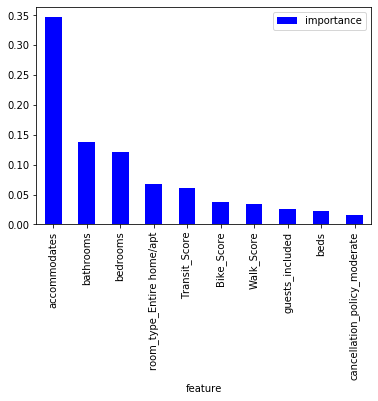

In [267]:
train_cols = basic_features + ammenity_features + neiborhood_score

target_col = 'price_holiday'

x_train = listings_train[train_cols].values
x_test = listings_test[train_cols].values
y_train = listings_train[target_col].values
y_test = listings_test[target_col].values

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

#Create a random forest regressor
clf = RandomForestRegressor(max_depth=10, n_estimators=100)

#Train the regressor
clf.fit(x_train, y_train)

#Plot variable importances for the top 10 predictors
importances = clf.feature_importances_
feat_names = train_cols
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result.sort_values(by='importance',ascending=False)[:10].plot(x='feature', y='importance', kind='bar',color='blue')

Training Data
R^2 value using score fn: 0.883
Root Mean Squared Error : 36.799
 ------------------------------------------ 
Test Data
R^2 value using score fn: 0.665
Root Mean Squared Error : 60.472
 ----------------------------------- 


Text(0.5, 1.0, 'Residuals for the model')

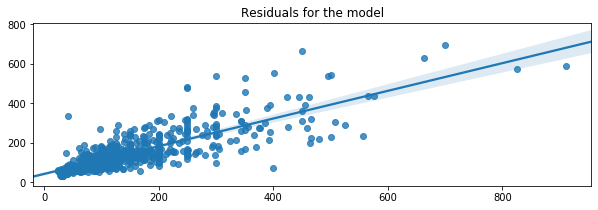

In [268]:
# Use the model to predict values
y_pred = clf.predict(x_train)

# Calculate the Mean Squared Error using the mean_squared_error function.
tree_train_rmse = (mean_squared_error(y_train,y_pred))**0.5
print("Training Data")
print("R^2 value using score fn: %.3f" % clf.score(x_train,y_train))
print("Root Mean Squared Error : %0.3f" % (tree_train_rmse))


print(" ------------------------------------------ ")
r_2_train_holiday.append(clf.score(x_train,y_train))
rmse_train_holiday.append(tree_train_rmse)

# Use the model to predict values
y_pred = clf.predict(x_test)

# Calculate the Mean Squared Error using the mean_squared_error function.
tree_test_rmse = (mean_squared_error(y_test,y_pred))**0.5
print("Test Data")
print("R^2 value using score fn: %.3f" % clf.score(x_test,y_test))
print("Root Mean Squared Error : %0.3f" % (tree_test_rmse))

print(" ----------------------------------- ")
r_2_test_holiday.append(clf.score(x_test,y_test))
rmse_test_holiday.append(tree_test_rmse)

# Plot of model's residuals:
fig = plt.figure(figsize=(10,3))

sns.regplot((y_test),(y_pred))
plt.title("Residuals for the model")

# Model 5: Catboost Regressor 
## Fill in all columns

In [269]:
# y = holiday_listings.price_holiday
# holiday_listings= holiday_listings[basic_features + ammenity_features + neiborhood_score]
# X = holiday_listings

In [270]:
numerical_data = []
categorical_data = []
for column in holiday_listings.columns:
    if holiday_listings[column].dtype == "object":
        categorical_data.append(column)
    else:
        numerical_data.append(column)

# prepare categorical features indices, catboost needs the indices of caterical data

In [271]:
X = holiday_listings
y = holiday_listings.price_holiday
# set the values of price to zero in predictors X
X['price_holiday'] = 0
X['price_nonholiday'] = 0

In [272]:
def column_index(df, query_cols):
    cols = holiday_listings.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, query_cols, sorter=sidx)]

categorical_feature_indices = column_index(X, categorical_data)

In [273]:
categorical_feature_indices

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 24, 25, 26, 27, 30, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 47, 48, 53, 59, 60, 65, 67, 68, 76, 77, 79], dtype=int64)

In [274]:
# train_cols = holiday_listings.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# target_col = 'price_holiday'
# x_train = listings_train[train_cols].values
# x_test = listings_test[train_cols].values
# y_train = listings_train[target_col].values
# y_test = listings_test[target_col].values
    
print("Shape of Train and Test data")
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(" ------------------------------------------ ")

Shape of Train and Test data
(3054, 121) (764, 121) (3054,) (764,)
 ------------------------------------------ 


In [275]:
# refinement
model =  CatBoostRegressor(iterations=700,
                             learning_rate=0.01,
                             depth=4,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)
model.fit(X_train, y_train,
                 eval_set=(X_test, y_test),
                 cat_features=categorical_feature_indices,
                 use_best_model=True,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 105.8213757	test: 109.3571991	best: 109.3571991 (0)	total: 46ms	remaining: 32.2s
75:	learn: 78.1465550	test: 86.0914842	best: 86.0914842 (75)	total: 3.32s	remaining: 27.2s
150:	learn: 66.2942592	test: 76.9733420	best: 76.9733420 (150)	total: 6.58s	remaining: 23.9s
225:	learn: 60.8149221	test: 72.6698714	best: 72.6698714 (225)	total: 9.83s	remaining: 20.6s
300:	learn: 57.8804065	test: 70.6330154	best: 70.6330154 (300)	total: 12.9s	remaining: 17.1s
375:	learn: 56.1153734	test: 69.4195616	best: 69.4195616 (375)	total: 16s	remaining: 13.7s
450:	learn: 54.9280702	test: 68.6852173	best: 68.6852173 (450)	total: 18.8s	remaining: 10.4s
525:	learn: 53.9682901	test: 68.2490043	best: 68.2490043 (525)	total: 21.7s	remaining: 7.18s
600:	learn: 53.2038396	test: 67.8834098	best: 67.8834098 (600)	total: 24.5s	remaining: 4.04s
675:	learn: 52.5088402	test: 67.6567695	best: 67.6567695 (675)	total: 27.5s	remaining: 976ms
699:	learn: 52.3081005	test: 67.5767320	best: 67.5767320 (699)	total: 28.5s	

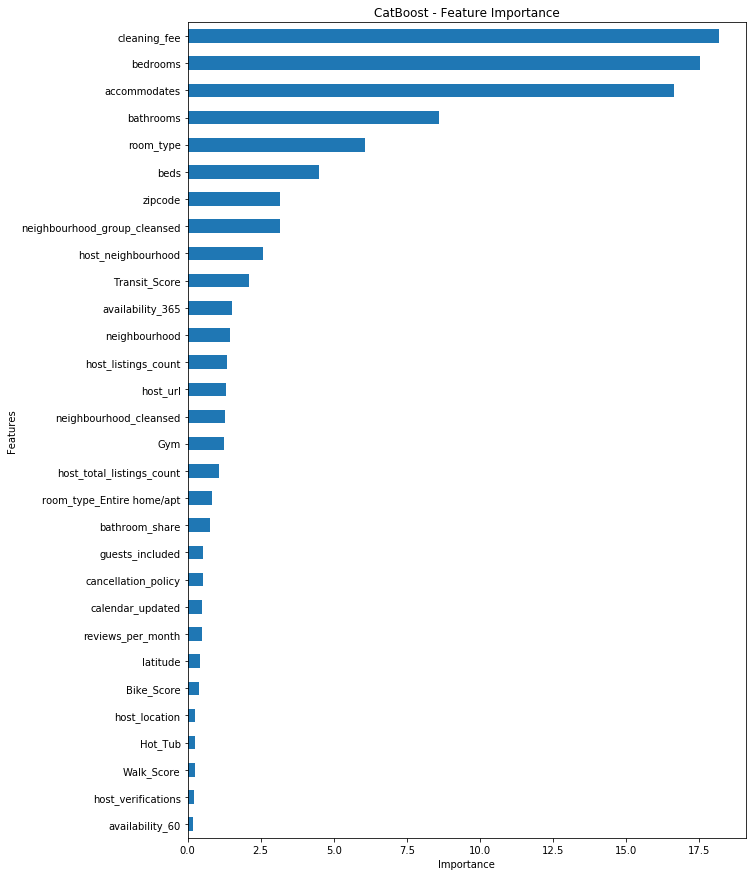

In [276]:
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': holiday_listings.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 15), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [277]:
fea_imp.sort_values(by='imp', ascending=False)

,imp,col
54,18.188465,cleaning_fee
51,17.537549,bedrooms
49,16.640274,accommodates
50,8.601925,bathrooms
48,6.062374,room_type
52,4.507383,beds
39,3.161330,zipcode
36,3.152848,neighbourhood_group_cleansed
27,2.578091,host_neighbourhood
1,2.095946,Transit_Score


In [278]:
# collect catboost rmse
rmse_train_holiday.append(model.best_score_['learn']['RMSE'])
rmse_test_holiday.append(model.best_score_['validation']['RMSE'])

In [279]:

r_2_train_holiday.append(model.score(X_train,y_train))
r_2_test_holiday.append(model.score(X_test,y_test))

# Models Comparison: Select the best model by comparing R^2 and RMSE
*
*
*
*


In [280]:
r_2_train_holiday

[0.5670220473416893,
 0.6062562174526978,
 0.6129663034156386,
 0.8833858345221597,
 0.7723384329635004]

In [281]:
r_2_test_holiday

[0.5599623978238853,
 0.6045739296127581,
 0.6100230430185278,
 0.6646312150679565,
 0.6214555018741028]

In [282]:
rmse_train_holiday

[70.90794882415459,
 67.61902211708706,
 67.04037274243835,
 36.79914138858639,
 52.308100516739906]

In [283]:
rmse_test_holiday

[69.26920504259422,
 65.66409427103254,
 65.21008733778481,
 60.472319584860784,
 67.57673197562029]

In [284]:
# Mode1: Linear Regression + Basic features
# Mode2: Linear Regression + Basic features + ammenity_features
# Mode3: Linear Regression + Basic features + ammenity_features + neighborhood features
# Mode4: Random Forest Regression + Basic features + ammenity_features + neighborhood features
# Model5: CatBoost Regression + All Features

In [285]:
y_coordinates = [r_2_train_holiday, r_2_test_holiday, rmse_train_holiday, rmse_test_holiday]
x_coordinates = ["Model1", "Model2", "Model3", "Model4", "Model5"]

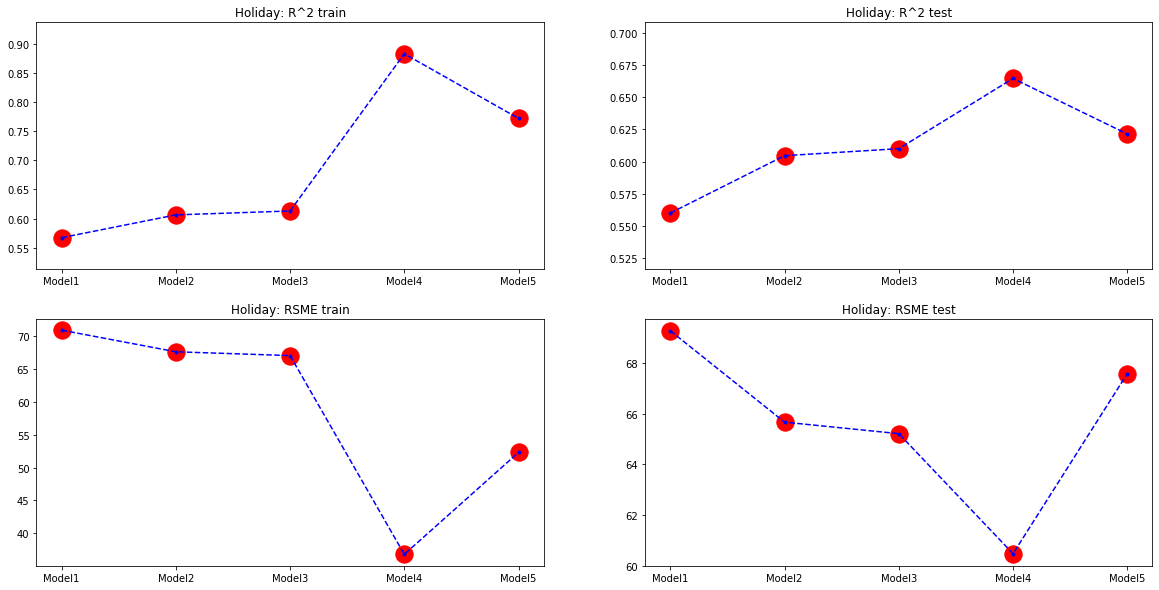

In [286]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))
y_coordinate_ = y_coordinates[0]
axs[0,0].set_title("Holiday: R^2 train")
axs[0,0].scatter(x_coordinates, y_coordinate_, s = 300, c='red')
axs[0,0].plot(x_coordinates, y_coordinate_, '.b--')

y_coordinate_ = y_coordinates[1]
axs[0,1].set_title("Holiday: R^2 test")
axs[0,1].scatter(x_coordinates, y_coordinate_, s = 300, c='red')
axs[0,1].plot(x_coordinates, y_coordinate_, '.b--')


y_coordinate_ = y_coordinates[2]
axs[1,0].set_title("Holiday: RSME train")
axs[1,0].scatter(x_coordinates, y_coordinate_, s = 300, c='red')
axs[1,0].plot(x_coordinates, y_coordinate_, '.b--')


y_coordinate_ = y_coordinates[3]
axs[1,1].set_title("Holiday: RSME test")
axs[1,1].scatter(x_coordinates, y_coordinate_, s = 300, c='red')
axs[1,1].plot(x_coordinates, y_coordinate_, '.b--')

# Model Comparison:
* Random Forest Regression with engineered features performs best with highest R2 0.66 and lowest RMSE of 60.47 on test dataset.
* Tree based models perform better than Linear Model.
* Feature engineerings can improve R2 and reduces RMSE.

# Model Results: 
## Use Model4 - Random Forest Regression to do the prediction
## Use Model3 - Linear Regression + Features to give detailed tips on pricing the properties 



## Top 10 important factors affecting price

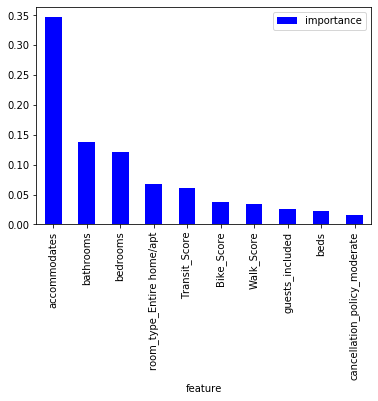

In [287]:
tree_result.sort_values(by='importance',ascending=False)[:10].plot(x='feature', y='importance', kind='bar',color='blue')

## Detailed tips:
* If the room type is Entire Home, the pricing tip of the listing increases by 68.95.
* For every one unit increase in number of bathrooms, the pricing tip of listing increases by 40.62.
* If the listing is access-friendly, there is an increase in 10.14 in the pricing tip.
* For every additional person that can be accommodated in the property, pricing tip increases by 16.01.
* Pricing tip is not really influenced by whether a host provides breakfast or not.
* If smoking is allowed, the pricing tip reduces by 11.32.
* It is generally observed that engineered features play a important role in determining the pricing tip.

### Ignore the below

# Use top features of Random Forest to train linear regression: not better than model3

Shape of Train and Test data
(3018, 20) (800, 20) (3018,) (800,)
 ------------------------------------------ 
Training Data
R^2 value using score fn: 0.607
Root Mean Squared Error : 67.577
 ------------------------------------------ 
Test Data
R^2 value using score fn: 0.604
Root Mean Squared Error : 65.715
 ------------------------------------------ 
                         Feature  Coefficient
1                      bathrooms    41.069089
3      room_type_Entire home/apt    40.103284
2                       bedrooms    26.975650
0                   accommodates    12.192069
14                       Kitchen     9.238750
18                  Pet_Friendly     6.605789
8                           beds     5.602975
19      Free_Parking_on_Premises     3.328036
4                  Transit_Score     0.669180
7                guests_included     0.281775
6                     Walk_Score     0.016717
5                     Bike_Score    -0.057194
17                            TV    -5.276055
11

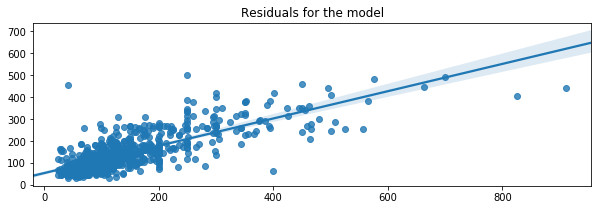

In [288]:
train_cols = tree_result.sort_values(by='importance',ascending=False)[:20]['feature'].values.tolist()
target_col = 'price_holiday'

model_listing(LinearRegression,train_cols,target_col)

# Use Model3 to get the coefficents of nonholiday_price

Shape of Train and Test data
(3018, 37) (800, 37) (3018,) (800,)
 ------------------------------------------ 
Training Data
R^2 value using score fn: 0.613
Root Mean Squared Error : 67.040
 ------------------------------------------ 
Test Data
R^2 value using score fn: 0.610
Root Mean Squared Error : 65.210
 ------------------------------------------ 
                         Feature  Coefficient
8      room_type_Entire home/apt    76.110268
9         room_type_Private room    40.751592
1                      bathrooms    40.639774
2                       bedrooms    28.104523
30               Smoking_Allowed    19.023153
0                   accommodates    11.990402
23                      Internet    10.028900
14              instant_bookable     6.822201
26                  Pet_Friendly     6.450042
3                           beds     6.089109
19           Family/Kid_Friendly     4.152666
24                       Kitchen     3.784348
20      Free_Parking_on_Premises     2.744292
29

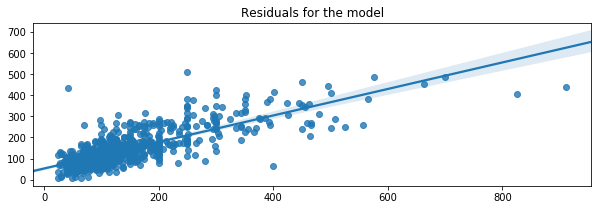

In [289]:
train_cols = basic_features + ammenity_features + neiborhood_score
target_col = 'price_holiday'

model_listing(LinearRegression,train_cols,target_col)

Shape of Train and Test data
(3018, 37) (800, 37) (3018,) (800,)
 ------------------------------------------ 
Training Data
R^2 value using score fn: 0.574
Root Mean Squared Error : 63.117
 ------------------------------------------ 
Test Data
R^2 value using score fn: 0.599
Root Mean Squared Error : 57.186
 ------------------------------------------ 
                         Feature  Coefficient
8      room_type_Entire home/apt    76.152278
1                      bathrooms    37.983245
9         room_type_Private room    37.267180
2                       bedrooms    29.850238
30               Smoking_Allowed    13.407393
23                      Internet     9.767031
20      Free_Parking_on_Premises     7.974540
0                   accommodates     7.553227
14              instant_bookable     6.724599
19           Family/Kid_Friendly     5.492033
15              24-Hour_Check-in     4.709992
3                           beds     4.624199
4                guests_included     3.790992
26

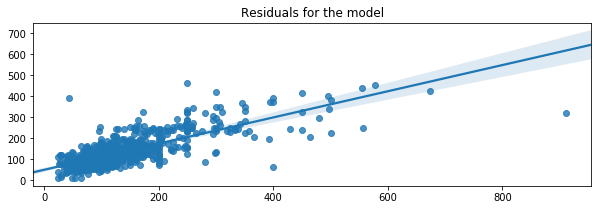

In [290]:
target_col = 'price_nonholiday'

model_listing(LinearRegression,train_cols,target_col)